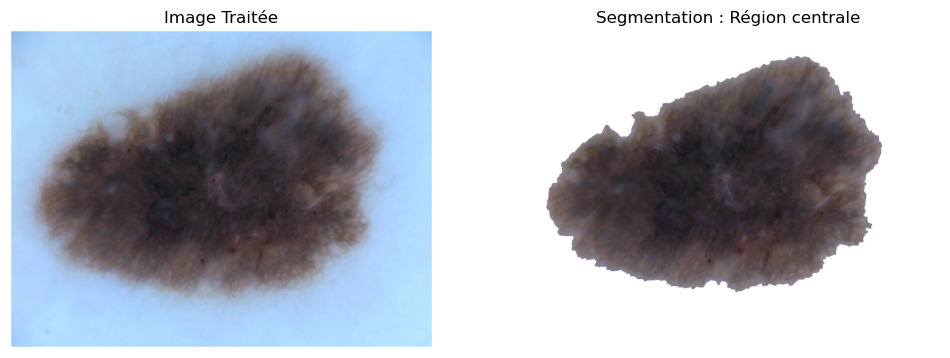

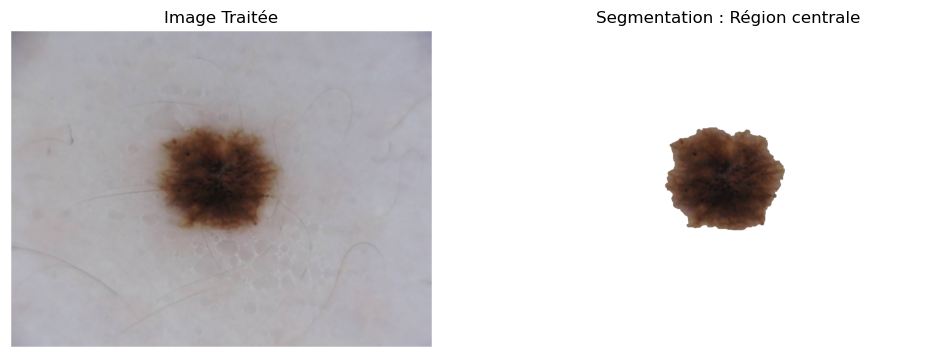

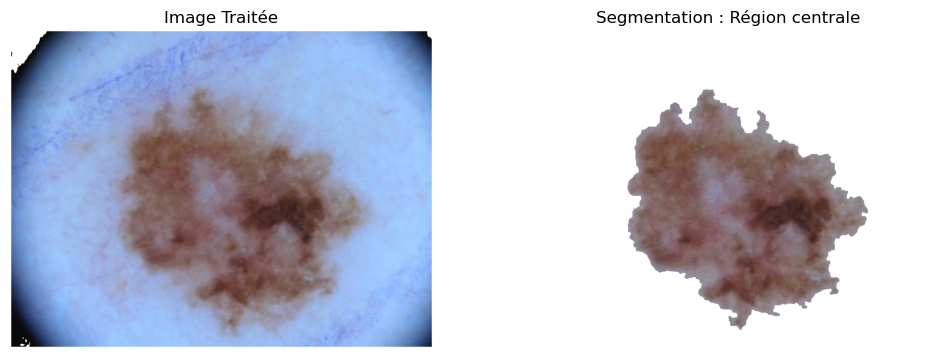

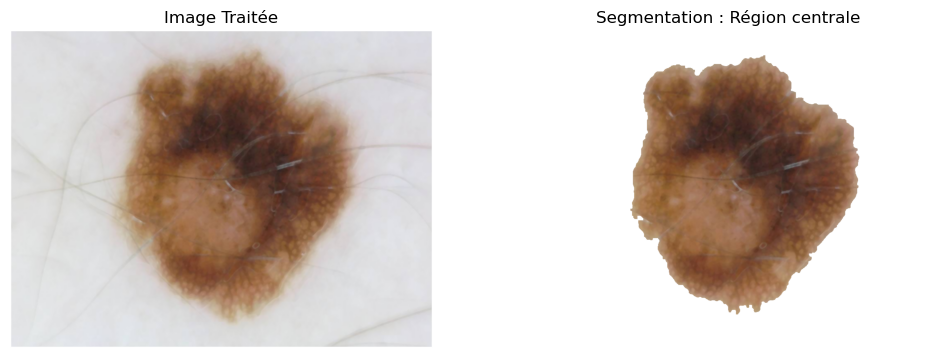

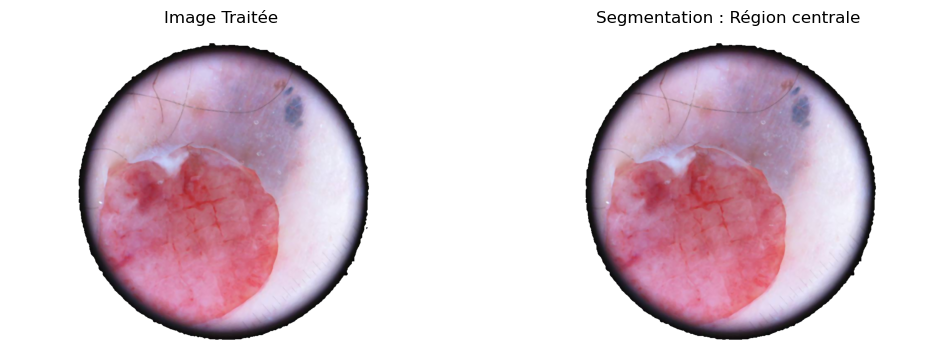

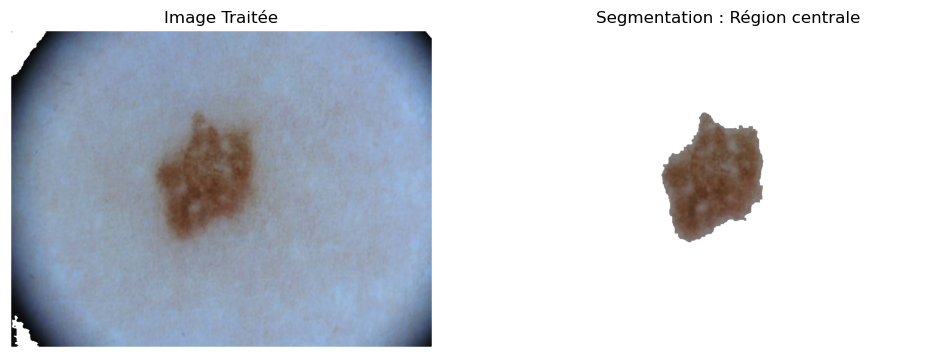

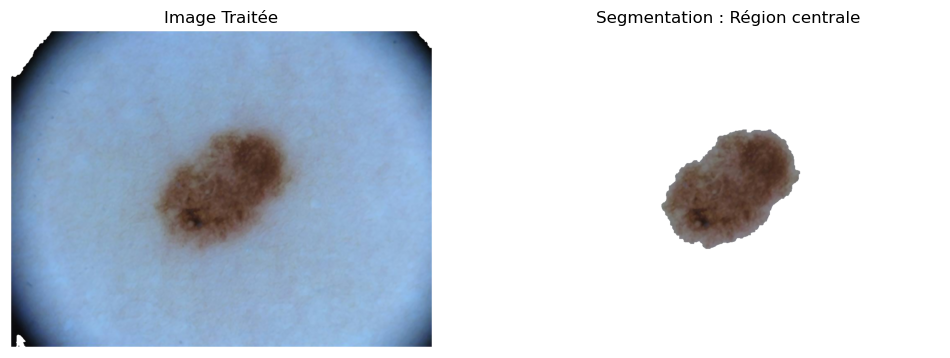

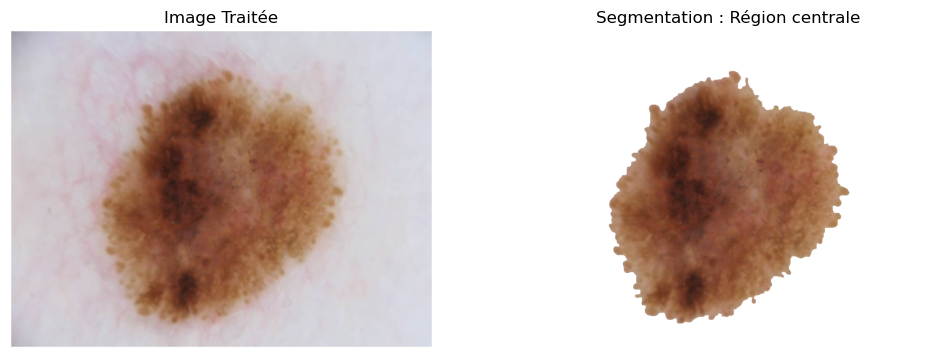

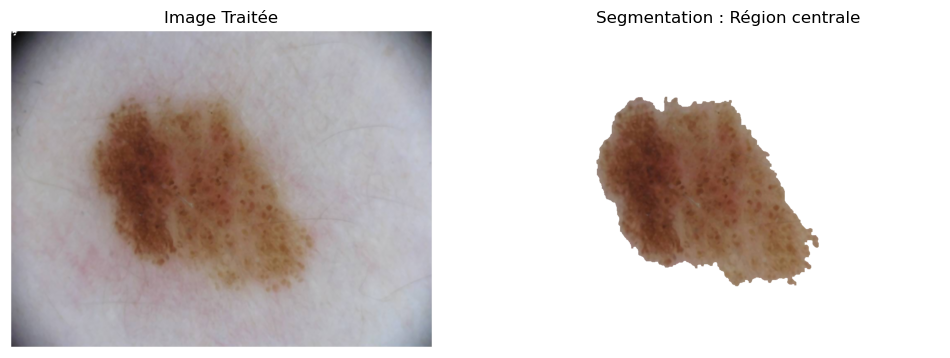

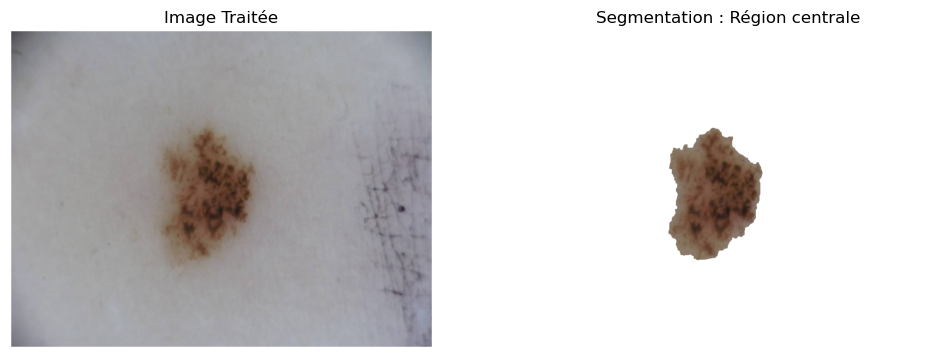

Caractéristiques sauvegardées dans tumor_features.csv


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from skimage.feature import graycomatrix, graycoprops

# ---------------------------
# Fonctions de segmentation
# ---------------------------
def remove_black_background(img, threshold=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([130, 255, threshold])
    mask = cv2.inRange(hsv, lower_black, upper_black)
    img[mask == 255] = [255, 255, 255]
    return img

def crop_and_add_white_ring(img, zoom_factor=5, ring_thickness=10):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img
    contour_scores = [cv2.arcLength(c, True) + cv2.contourArea(c) for c in contours]
    best_contour = contours[np.argmax(contour_scores)]
    x, y, w, h = cv2.boundingRect(best_contour)
    x1 = max(0, x - w // zoom_factor)
    y1 = max(0, y - h // zoom_factor)
    x2 = min(img.shape[1], x + w + w // zoom_factor)
    y2 = min(img.shape[0], y + h + h // zoom_factor)
    roi = img[y1:y2, x1:x2].copy()
    mask = np.zeros(roi.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [best_contour], -1, 255, ring_thickness)
    roi[mask == 255] = [255, 255, 255]
    return roi

def segmentation_kmeans(image, k=2):
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=50, n_init=10)
    labels = kmeans.fit_predict(pixels)
    return labels.reshape(image.shape[:2])

def extract_central_region(segmentation):
    h, w = segmentation.shape
    kernel = np.ones((5, 5), np.uint8)
    clean_mask = cv2.morphologyEx(segmentation, cv2.MORPH_OPEN, kernel)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel)
    num_labels, labels_cc, stats, centroids = cv2.connectedComponentsWithStats(clean_mask, connectivity=8)
    center_label = labels_cc[h // 2, w // 2]
    final_mask = np.uint8(labels_cc == center_label) * 255
    return final_mask

def fill_holes(mask):
    im_floodfill = mask.copy()
    h, w = mask.shape[:2]
    floodfill_mask = np.zeros((h + 2, w + 2), np.uint8)
    cv2.floodFill(im_floodfill, floodfill_mask, (0, 0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    filled_mask = mask | im_floodfill_inv
    return filled_mask

def apply_median_filter(img, ksize=5):
    return cv2.medianBlur(img, ksize)

def create_colored_segmentation(image, final_mask):
    segmented_output = np.full_like(image, 255)
    segmented_output[final_mask == 255] = image[final_mask == 255]
    return segmented_output

# ---------------------------
# Fonctions d'extraction des caractéristiques
# ---------------------------
def get_mask_from_colored_output(colored_output):
    """
    Dans colored_output, le fond est blanc ([255,255,255]). On considère
    que les pixels non blancs correspondent à la région d'intérêt.
    """
    mask = np.where(np.all(colored_output == [255, 255, 255], axis=-1), 0, 255).astype(np.uint8)
    return mask

def extract_color_features(colored_output, mask):
    hsv_img = cv2.cvtColor(colored_output, cv2.COLOR_RGB2HSV)
    lab_img = cv2.cvtColor(colored_output, cv2.COLOR_RGB2LAB)
    hsv_pixels = hsv_img[mask == 255]
    lab_pixels = lab_img[mask == 255]
    if hsv_pixels.size == 0 or lab_pixels.size == 0:
        return np.array([0, 0, 0]), np.array([0, 0, 0])
    hsv_mean = np.mean(hsv_pixels, axis=0)
    lab_mean = np.mean(lab_pixels, axis=0)
    return hsv_mean, lab_mean

def extract_texture_features(colored_output, mask):
    gray_img = cv2.cvtColor(colored_output, cv2.COLOR_RGB2GRAY)
    coords = np.where(mask == 255)
    if len(coords[0]) == 0:
        return 0, 0, 0, 0
    min_row, max_row = np.min(coords[0]), np.max(coords[0])
    min_col, max_col = np.min(coords[1]), np.max(coords[1])
    roi = gray_img[min_row:max_row + 1, min_col:max_col + 1]
    roi_quantized = np.uint8(roi / 32)  # 8 niveaux (0 à 7)
    glcm = graycomatrix(roi_quantized, distances=[1], angles=[0], levels=8, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    return contrast, dissimilarity, homogeneity, energy

def extract_shape_features(mask):
    area = np.sum(mask == 255)
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 0, 0, 0
    cnt = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(cnt, True)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h if h != 0 else 0
    return area, perimeter, aspect_ratio

# ---------------------------
# Pipeline principal
# ---------------------------
# Chemin vers le dataset
base_path = r"C:/Users/abdel/OneDrive/Documents/ISIC-2017_Training_Data"
files = sorted([f for i, f in enumerate(os.listdir(base_path))
                if f.lower().endswith(('.jpg', '.jpeg', '.png')) and i % 2 == 1])
files = files[:10]  # Limiter à 10 images pour la démo

features_list = []  # Pour stocker les caractéristiques de chaque image

for file in files:
    image_path = os.path.join(base_path, file)
    image = cv2.imread(image_path)
    
    # 1. Remplacer le fond noir par du blanc
    image = remove_black_background(image, threshold=9)
    
    # 2. Appliquer un filtre médian
    image_filtered = apply_median_filter(image, ksize=5)
    
    # 3. Extraire la région d'intérêt avec zoom et anneau blanc
    image_cropped = crop_and_add_white_ring(image_filtered, zoom_factor=10, ring_thickness=3)
    image_rgb = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB)
    
    # 4. Segmentation par K-Means en 2 régions
    segmentation = segmentation_kmeans(image_rgb, k=2)
    h, w = segmentation.shape
    center_label = segmentation[h // 2, w // 2]
    binary_mask = (segmentation == center_label).astype(np.uint8) * 255
    
    # 5. Ne garder que la composante connexe qui contient le centre
    final_mask = extract_central_region(binary_mask)
    
    # 6. Remplir les trous dans le masque
    final_mask = fill_holes(final_mask)
    
    # 7. Création de l'image finale (colored_output)
    colored_output = create_colored_segmentation(image_rgb, final_mask)
    
    # Affichage (optionnel)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Image Traitée")
    plt.subplot(1, 2, 2)
    plt.imshow(colored_output)
    plt.axis("off")
    plt.title("Segmentation : Région centrale")
    plt.show()
    
    # ---------------------------
    # Extraction des caractéristiques à partir de colored_output
    # ---------------------------
    mask_features = get_mask_from_colored_output(colored_output)
    hsv_mean, lab_mean = extract_color_features(colored_output, mask_features)
    contrast, dissimilarity, homogeneity, energy = extract_texture_features(colored_output, mask_features)
    area, perimeter, aspect_ratio = extract_shape_features(mask_features)
    
    features_list.append([
        file,
        hsv_mean[0], hsv_mean[1], hsv_mean[2],
        lab_mean[0], lab_mean[1], lab_mean[2],
        contrast, dissimilarity, homogeneity, energy,
        area, perimeter, aspect_ratio
    ])

# Enregistrer les caractéristiques dans un fichier CSV
columns = ["File Name", "HSV_H", "HSV_S", "HSV_V",
           "LAB_L", "LAB_A", "LAB_B",
           "Contrast", "Dissimilarity", "Homogeneity", "Energy",
           "Area", "Perimeter", "Aspect_Ratio"]
df = pd.DataFrame(features_list, columns=columns)
df.to_csv("tumor_features.csv", index=False)
print("Caractéristiques sauvegardées dans tumor_features.csv")
